## FCNN without dataslicing

In [ ]:
import librosa
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import json


In [ ]:
sample_rate = 22050
n_mels = 130
hop_length = 512
n_frames = 13
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

In [ ]:
def augment_audio(audio, sr):

    audio_shifted = librosa.effects.pitch_shift(audio, n_steps=np.random.randint(-2, 2), sr=sr)
    audio_stretched = librosa.effects.time_stretch(audio, rate=np.random.uniform(0.8, 1.2))
    return audio_shifted, audio_stretched

In [ ]:
data_path = '/content/sample_data/data.json'

with open(data_path, "r") as fp:
    data = json.load(fp)

# Define X nd y
X = np.array(data["mfcc"])
y = np.array(data["genre_num"])
# Train-validation-test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

X_train = X_train[..., np.newaxis]  # Add channel dimension
X_val = X_val[..., np.newaxis]      # Add channel dimension
X_test = X_test[..., np.newaxis]    # Add channel dimension

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Dense

def build_fcnn(input_shape=(n_mels, n_frames, 1),num_classes=10):
    model = Sequential([
        #layer 1
        Conv2D(32, (3,3), activation='relu',padding='same',input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        #layer 2
        Conv2D(64, (3,3), activation='relu',padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        #layer 3
        Conv2D(128, (3,3), activation='relu',padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        #layer 4
        Conv2D(128, (3,3), activation='relu',padding='same'),
        BatchNormalization(),
        GlobalAveragePooling2D(), #Replaces dense layers
        Dropout(0.3),
        Dense(64, activation='softmax')
    ])

    return model

In [ ]:
import tensorflow as tf
print("GPU available:", tf.config.list_physical_devices('GPU'))

GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Step 5: Build, compile, and summarize model
from tensorflow.keras.optimizers import Adam
model = build_fcnn()
model.compile(optimizer=Adam(learning_rate=0.001),  # Default Adam LR
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 130, 13, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 130, 13, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 65, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 65, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 65, 6, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 65, 6, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 3, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 3, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 3, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 3, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 1, 128)     │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 1, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 249,920 (976.25 KB)

 Trainable params: 249,216 (973.50 KB)

 Non-trainable params: 704 (2.75 KB)

## Training

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

# Step 6: Train model on T4 GPU
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=250,
                    batch_size=64,
                    callbacks=[early_stopping,lr_scheduler])
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test_accuracy : {test_accuracy:.4f}")

Epoch 1/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 21s 127ms/step - accuracy: 0.2948 - loss: 3.0047 - val_accuracy: 0.2003 - val_loss: 4.5167 - learning_rate: 0.0010
Epoch 2/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5747 - loss: 1.3837 - val_accuracy: 0.4764 - val_loss: 1.5750 - learning_rate: 0.0010
Epoch 3/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6304 - loss: 1.1379 - val_accuracy: 0.5627 - val_loss: 1.2544 - learning_rate: 0.0010
Epoch 4/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6795 - loss: 0.9955 - val_accuracy: 0.5784 - val_loss: 1.3065 - learning_rate: 0.0010
Epoch 5/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7102 - loss: 0.8910 - val_accuracy: 0.6271 - val_loss: 1.1354 - learning_rate: 0.0010
Epoch 6/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7175 - loss: 0.8308 - val_accuracy: 0.6237 - val_loss: 1.3123 - learning_rate: 0.0010
Epoch 7/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7472 - loss: 0.7252 - val_

In [ ]:
model.save('/content/sample_data/fcnn_melspec_gtzan.h5')

## FCNN with data slicing

Loading and preprocessing data...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 130, 130, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 130, 130, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 65, 65, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 65, 65, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 65, 65, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 65, 65, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,394 (95.29 KB)

 Trainable params: 24,170 (94.41 KB)

 Non-trainable params: 224 (896.00 B)

Training model...
Epoch 1/250
306/306 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.2161 - loss: 2.1329 - val_accuracy: 0.2613 - val_loss: 1.9176 - learning_rate: 1.0000e-04
Epoch 2/250
306/306 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.3304 - loss: 1.8551 - val_accuracy: 0.3019 - val_loss: 1.8205 - learning_rate: 1.0000e-04
Epoch 3/250
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3853 - loss: 1.7062 - val_accuracy: 0.3591 - val_loss: 1.7123 - learning_rate: 1.0000e-04
Epoch 4/250
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4435 - loss: 1.5469 - val_accuracy: 0.4192 - val_loss: 1.5391 - learning_rate: 1.0000e-04
Epoch 5/250
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4582 - loss: 1.4912 - val_accuracy: 0.4616 - val_loss: 1.4501 - learning_rate: 1.0000e-04
Epoch 6/250
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4841 - loss: 1.4424 - val_accuracy: 0.4678 - val_loss: 1.4161 - learning_rate: 1.0000e-04
Epoch 7/250
306/306 ━━━━━━━━━━━━━━━━━

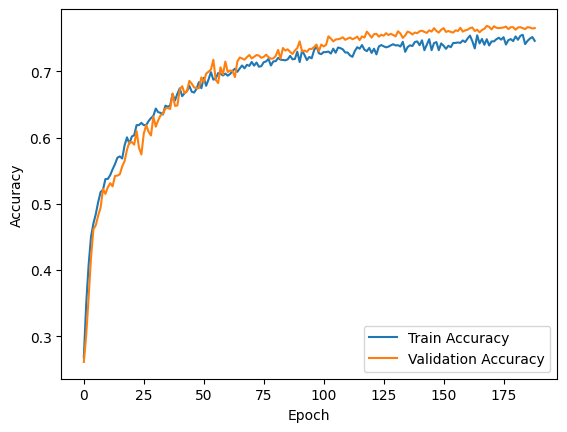

In [ ]:
import librosa
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

# Enable mixed precision for faster GPU training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Parameters
sample_rate = 22050
n_mels = 130
hop_length = 512
segment_length = 3  # 3-second clips
n_frames = int((segment_length * sample_rate / hop_length) + 1)  # ~129 for 3 seconds
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
batch_size = 16
data_path = '/content/sample_data/data.json'  # Update with your GTZAN dataset path

# Function to split audio into 3-second segments
def split_audio(audio, sr, segment_length=3):
    samples_per_segment = int(segment_length * sr)
    segments = [audio[i:i + samples_per_segment] for i in range(0, len(audio), samples_per_segment)]
    return segments



# Load dataset
print("Loading and preprocessing data...")

with open(data_path, "r") as fp:
    data = json.load(fp)

# Define X nd y
X = np.array(data["mfcc"])
y = np.array(data["genre_num"])
# Train-validation-test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

X_train = X_train[..., np.newaxis]  # Add channel dimension
X_val = X_val[..., np.newaxis]      # Add channel dimension
X_test = X_test[..., np.newaxis]    # Add channel dimension


# Create tf.data datasets for efficient loading
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Build simpler FCNN
def build_fcnn(input_shape=(n_mels, n_frames, 1), num_classes=10):
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        GlobalAveragePooling2D(),
        Dropout(0.3),
        Dense(num_classes, activation='softmax', dtype='float32')  # Mixed precision output
    ])
    return model

# Build and compile model
model = build_fcnn()
model.compile(optimizer=Adam(learning_rate=0.0001),  # Default Adam LR
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

# Train with early stopping
# Step 6: Train model on T4 GPU
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)

print("Training model...")
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=250,
    callbacks=[early_stopping,lr_scheduler]
)

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot training/validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model.save('/content/sample_data/fcnn_splice_songs_model.h5')

## FCNN with data augmentation

Loading and preprocessing data...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 130, 130, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 130, 130, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 65, 65, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 65, 65, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 65, 65, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 65, 65, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,394 (95.29 KB)

 Trainable params: 24,170 (94.41 KB)

 Non-trainable params: 224 (896.00 B)

Training model...
Epoch 1/250
153/153 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.1735 - loss: 2.2694 - val_accuracy: 0.2656 - val_loss: 2.0975 - learning_rate: 1.0000e-04
Epoch 2/250
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3529 - loss: 1.8371 - val_accuracy: 0.3338 - val_loss: 1.8692 - learning_rate: 1.0000e-04
Epoch 3/250
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3985 - loss: 1.6930 - val_accuracy: 0.3815 - val_loss: 1.7301 - learning_rate: 1.0000e-04
Epoch 4/250
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4328 - loss: 1.5730 - val_accuracy: 0.4235 - val_loss: 1.5929 - learning_rate: 1.0000e-04
Epoch 5/250
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4769 - loss: 1.4810 - val_accuracy: 0.4669 - val_loss: 1.4873 - learning_rate: 1.0000e-04
Epoch 6/250
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4879 - loss: 1.4347 - val_accuracy: 0.4964 - val_loss: 1.4274 - learning_rate: 1.0000e-04
Epoch 7/250
153/153 ━━━━━━━━━━━━━━━━━━

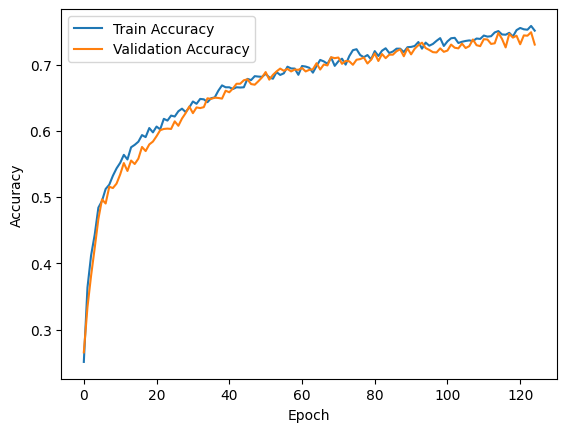

In [ ]:
import librosa
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import json

# Enable mixed precision
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Parameters
sample_rate = 22050
n_mels = 130
hop_length = 512
segment_length = 3  # 3-second clips
n_frames = int((segment_length * sample_rate / hop_length) + 1)  # ~129
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
batch_size = 32  # Increased for GPU
data_path = '/content/sample_data/data.json'  # Update with your GTZAN dataset path

# Audio augmentations
def augment_audio(audio, sr):
    # Time-reversal (50% chance)
    if np.random.rand() < 0.5:
        audio = audio[::-1]
    # Pitch shift (±2 semitones, 50% chance)
    if np.random.rand() < 0.5:
        n_steps = np.random.uniform(-2, 2)
        audio = librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)
    # Time stretch (0.8–1.2 rate, 50% chance)
    if np.random.rand() < 0.5:
        rate = np.random.uniform(0.8, 1.2)
        audio = librosa.effects.time_stretch(audio, rate=rate)
    return audio

# Load dataset
print("Loading and preprocessing data...")

with open(data_path, "r") as fp:
    data = json.load(fp)

# Define X nd y
X = np.array(data["mfcc"])
y = np.array(data["genre_num"])

# Train-validation-test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

X_train = X_train[..., np.newaxis]  # Add channel dimension
X_val = X_val[..., np.newaxis]      # Add channel dimension
X_test = X_test[..., np.newaxis]    # Add channel dimension

# Create tf.data datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Build FCNN
def build_fcnn(input_shape=(n_mels, n_frames, 1), num_classes=10):
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        GlobalAveragePooling2D(),
        Dropout(0.3),
        Dense(num_classes, activation='softmax', dtype='float32')
    ])
    return model

# Build and compile model
model = build_fcnn()
model.compile(optimizer=Adam(learning_rate=0.0001),  # Default Adam LR
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

# Train with early stopping
# Step 6: Train model on T4 GPU
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
# Train
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
print("Training model...")
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=250,
    callbacks=[early_stopping,lr_scheduler]
)

# Evaluate
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot results
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model.save('fcnn_genre_classification_data_aug_model.h5')